In [1]:
import numpy as np
#np.set_printoptions(threshold = np.nan, linewidth = 115)
import pickle

# Load with pickle instead of processing images again
training_img_1 = pickle.load(open('1vAll_img_res_Infiltration_1st_half.p', 'rb'))
training_img_2 = pickle.load(open('1vAll_img_res_Infiltration_2nd_half.p', 'rb'))

In [2]:
training_img_one = np.append(training_img_1, training_img_2, axis=0)

In [3]:
training_img_3 = pickle.load(open('1vAll_img_res_Infiltration_3rd_half.p', 'rb'))
training_img_4 = pickle.load(open('1vAll_img_res_Infiltration_4th_half.p', 'rb'))

In [4]:
training_img_two = np.append(training_img_3, training_img_4, axis=0)

In [5]:
training_img = np.append(training_img_one, training_img_two, axis=0)

training_img.shape

(36298, 256, 256, 1)

In [6]:
labels_1 = pickle.load(open('1vAll_labels_res_Infiltration_1st_half.p', 'rb'))
labels_2 = pickle.load(open('1vAll_labels_res_Infiltration_2nd_half.p', 'rb'))
labels_3 = pickle.load(open('1vAll_labels_res_Infiltration_3rd_half.p', 'rb'))
labels_4 = pickle.load(open('1vAll_labels_res_Infiltration_4th_half.p', 'rb'))

In [7]:
training_labels = np.append(labels_1, np.append(labels_2, np.append(labels_3, labels_4, axis = 0), axis = 0), axis = 0)

In [8]:
test_img = pickle.load(open('1vAll_test_img.p', 'rb'))
test_labels = pickle.load(open('1vAll_test_labels.p', 'rb'))

print('Labels shape: ', training_labels.shape)
print('Length of test_labels: ', len(test_labels))
print('No. of Infiltration Diagnoses: ', sum(training_labels))

Labels shape:  (36298,)
Length of test_labels:  3490
No. of Infiltration Diagnoses:  18149


In [68]:
import keras
from keras import models, optimizers, layers, regularizers, metrics, losses
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ReLU, ThresholdedReLU
from keras.layers.core import Dense, Dropout, SpatialDropout2D, Activation
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import model_from_json, Sequential

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)

import matplotlib.pyplot as plt

IMG_SIZE = 256

# Save Comparison model
def save_model(model_name, hist_str, model_str):

    pickle.dump(model_name.history, open('Training Histories/'+ hist_str + '.p', 'wb'))
    
    print("Saved " + hist_str + " to Training Histories folder")
    
    # serialize model to JSON
    model_name = model.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    model.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")
    
# Load model architecture and weights NOTE: must compile again
def load_model():
    model_str = str(input("Name of model to load: "))

    # load json and create model
    json_file = open('CNN Models/' + model_str + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("CNN Models/" + model_str + ".h5")
    print("Loaded " + model_str + " and weights from CNN Models folder")
    
    return loaded_model
    
# Load history object
def load_history():
    hist_str = str(input("Name of history to load: "))

    loaded_history = pickle.load(open('Training Histories/' + hist_str + '.p', 'rb'))
    
    print("Loaded " + hist_str + " from Training Histories folder")
    
    return loaded_history

Infiltration_class_weight = [{0: 1, 1: 12.938}]

### Custom Loss function
#from keras import backend as K

#def LSEP(true_label, pred_label):
#    return K.log(1 + K.sum(K.exp(true_label - pred_label)))


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    _fontsize = 'xx-large'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=_fontsize)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize=_fontsize) 
    plt.yticks(tick_marks, classes, fontsize=_fontsize)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + 0.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black', 
                fontsize=_fontsize)
    
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=_fontsize)
    plt.xlabel('Predicted Labels', fontsize=_fontsize)

# Metric Analysis
def _1vAll_accuracy(y_test, pred):
    
    pred = np.squeeze(pred, axis = -1)
    pred = np.round_(pred)
    pred = pred.astype(dtype = 'uint8')
    
    ft = pred == y_test
    
    accuracy = sum(ft)/len(ft)
        
    print('\t Complete Label Accuracy: %.2f' % round((accuracy * 100), 2), '%')
    
    print('Sum of Fully Correct Predictions: ', sum(ft))
    print('\t\t    Total Labels: ', len(ft))
    
    return accuracy

### One Vs. All

Train on 31760 samples, validate on 4538 samples
Epoch 1/100
 - 45s - loss: 12.8315 - acc: 0.5674 - val_loss: 11.3451 - val_acc: 0.0000e+00
Epoch 2/100
 - 43s - loss: 11.0185 - acc: 0.5714 - val_loss: 10.9775 - val_acc: 0.0000e+00
Epoch 3/100
 - 43s - loss: 10.6916 - acc: 0.5714 - val_loss: 10.7625 - val_acc: 0.0000e+00
Epoch 4/100
 - 43s - loss: 10.3870 - acc: 0.5714 - val_loss: 10.3273 - val_acc: 0.0000e+00
Epoch 5/100
 - 43s - loss: 10.1010 - acc: 0.5714 - val_loss: 10.2044 - val_acc: 0.0000e+00
Epoch 6/100
 - 43s - loss: 9.8304 - acc: 0.5714 - val_loss: 9.7888 - val_acc: 0.0000e+00
Epoch 7/100
 - 43s - loss: 9.5734 - acc: 0.5714 - val_loss: 9.6856 - val_acc: 0.0000e+00
Epoch 8/100
 - 43s - loss: 9.3288 - acc: 0.5714 - val_loss: 9.3419 - val_acc: 0.0000e+00
Epoch 9/100
 - 43s - loss: 9.0948 - acc: 0.5714 - val_loss: 9.2076 - val_acc: 0.0000e+00
Epoch 10/100
 - 43s - loss: 8.8708 - acc: 0.5714 - val_loss: 8.8701 - val_acc: 0.0000e+00
Epoch 11/100
 - 43s - loss: 8.6556 - acc: 0.5714 -

Epoch 92/100
 - 43s - loss: 3.6686 - acc: 0.5714 - val_loss: 3.8161 - val_acc: 0.0000e+00
Epoch 93/100
 - 43s - loss: 3.6610 - acc: 0.5714 - val_loss: 3.8330 - val_acc: 0.0000e+00
Epoch 94/100
 - 43s - loss: 3.6536 - acc: 0.5714 - val_loss: 3.7990 - val_acc: 0.0000e+00
Epoch 95/100
 - 43s - loss: 3.6465 - acc: 0.5714 - val_loss: 3.8189 - val_acc: 0.0000e+00
Epoch 96/100
 - 43s - loss: 3.6398 - acc: 0.5714 - val_loss: 3.7895 - val_acc: 0.0000e+00
Epoch 97/100
 - 43s - loss: 3.6332 - acc: 0.5714 - val_loss: 3.8032 - val_acc: 0.0000e+00
Epoch 98/100
 - 43s - loss: 3.6270 - acc: 0.5714 - val_loss: 3.7801 - val_acc: 0.0000e+00
Epoch 99/100
 - 43s - loss: 3.6210 - acc: 0.5714 - val_loss: 3.7933 - val_acc: 0.0000e+00
Epoch 100/100
 - 43s - loss: 3.6152 - acc: 0.5714 - val_loss: 3.7762 - val_acc: 0.0000e+00
	 Complete Label Accuracy: 50.00 %
Sum of Fully Correct Predictions:  1745
		    Total Labels:  3490
Saved 1vAll_Nadam_100e_history to Training Histories folder
Saved 1vAll_Nadam_100e and w

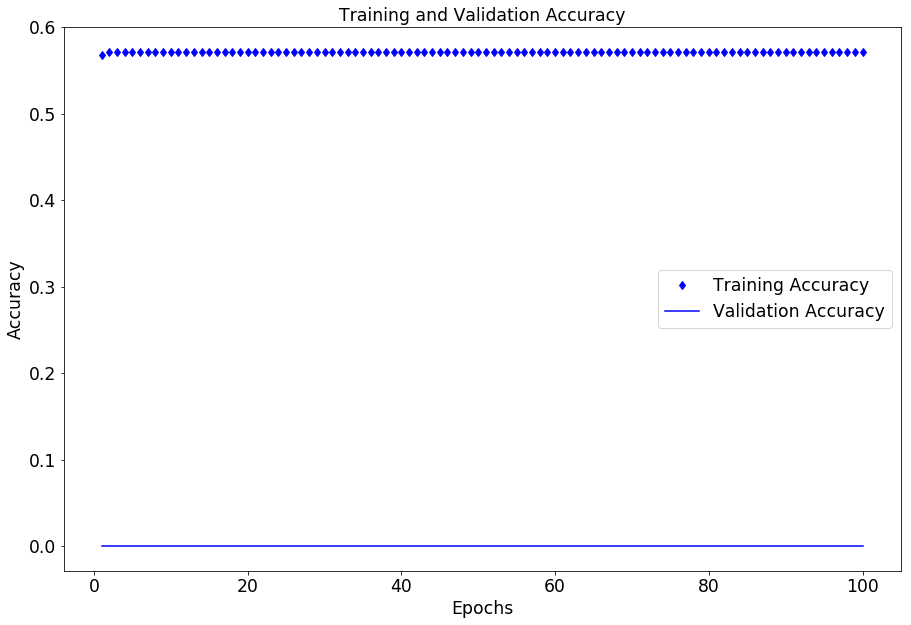

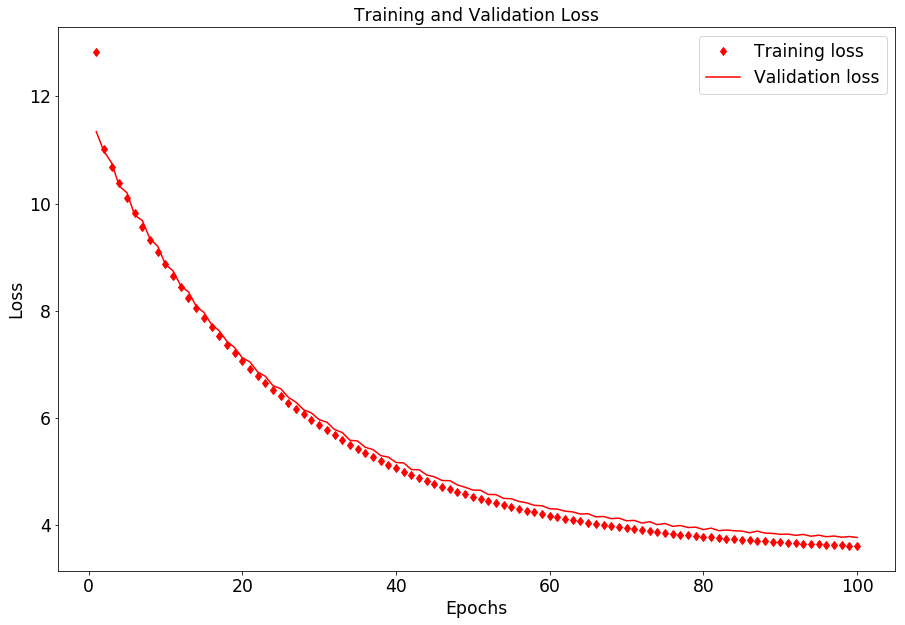

Normalized Confusion Matrix


<Figure size 432x288 with 0 Axes>

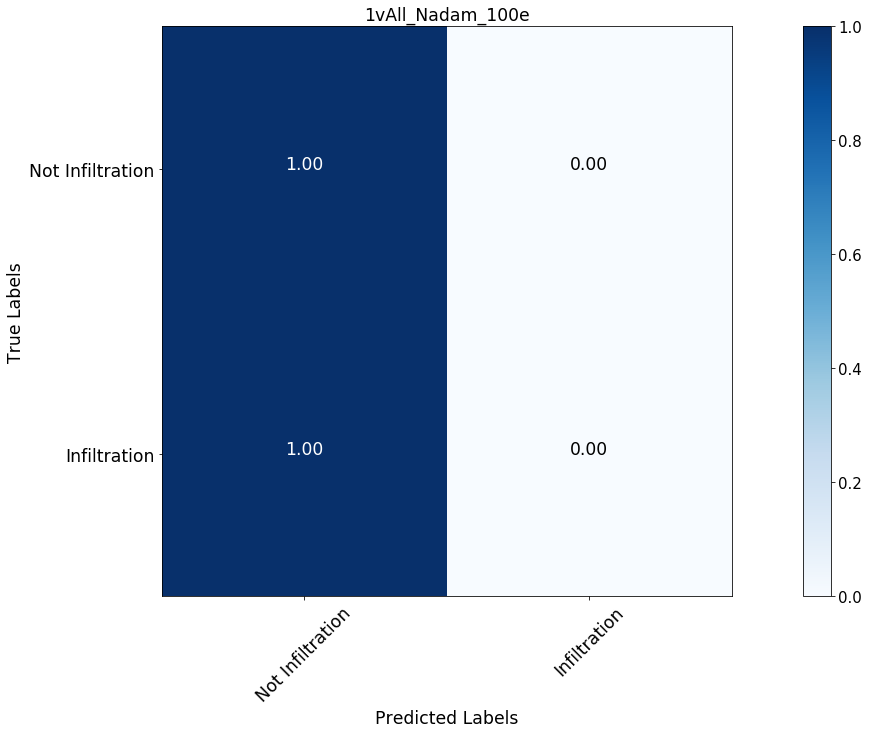

In [71]:
# Infiltration One Vs. All - Nesterov Adam Optimizer

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005), input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

# Last model: 1vAll_Nadam_100e
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.Nadam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 100, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 128, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_Nadam_100e_history'
model_str   = '1vAll_Nadam_100e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.plot(epochs, acc, 'bd', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(epochs, loss, 'rd', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (20, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

In [72]:
# Last model: Infiltration_1vAll_125e
model = load_model()
model.summary()

Name of model to load: Infiltration_1vAll_125e
Loaded Infiltration_1vAll_125e and weights from CNN Models folder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        9248      
_____________________________

In [ ]:
model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#model_obj = model.fit(training_img, training_labels, 
#                      epochs = 150, initial_epoch = 125, 
#                      validation_split = (1 / 8), 
#                      batch_size = 64, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'Infiltration_1vAll_150e_history'
model_str   = 'Infiltration_1vAll_150e'
    
#save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.plot(epochs, acc, 'bd', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(epochs, loss, 'rd', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (20, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = 'Infiltration_1vAll_125e', normalize=True)
#save_plt(fig)

In [ ]:
# Infiltration One Vs. All
# v2: More layers

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.005), 
                        input_shape=(IMG_SIZE, IMG_SIZE, 1)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))

model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

In [70]:
# Last model: Infiltration_1vAll_v2_100e
model = load_model()
#model.summary()

model.compile(optimizer = optimizers.Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 150, initial_epoch = 100, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'Infiltration_1vAll_v2_150e_history'
model_str   = 'Infiltration_1vAll_v2_150e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.plot(epochs, acc, 'bd', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(epochs, loss, 'rd', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (20, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

Name of model to load: Infiltration_1vAll_v2_100e
Loaded Infiltration_1vAll_v2_100e and weights from CNN Models folder
Train on 31760 samples, validate on 4538 samples
Epoch 101/150
 - 52s - loss: 0.6617 - acc: 0.6228 - val_loss: 0.9033 - val_acc: 0.2768
Epoch 102/150
 - 49s - loss: 0.6599 - acc: 0.6249 - val_loss: 0.8348 - val_acc: 0.2810
Epoch 103/150
 - 49s - loss: 0.6607 - acc: 0.6237 - val_loss: 0.7983 - val_acc: 0.3962
Epoch 104/150
 - 49s - loss: 0.6613 - acc: 0.6226 - val_loss: 1.0530 - val_acc: 0.2876
Epoch 105/150
 - 50s - loss: 0.6618 - acc: 0.6208 - val_loss: 0.8051 - val_acc: 0.4520
Epoch 106/150
 - 50s - loss: 0.6609 - acc: 0.6242 - val_loss: 0.9224 - val_acc: 0.2719
Epoch 107/150
 - 49s - loss: 0.6623 - acc: 0.6216 - val_loss: 0.7168 - val_acc: 0.4766
Epoch 108/150
 - 49s - loss: 0.6608 - acc: 0.6216 - val_loss: 0.8745 - val_acc: 0.3026
Epoch 109/150
 - 49s - loss: 0.6597 - acc: 0.6264 - val_loss: 0.9085 - val_acc: 0.3356
Epoch 110/150
 - 49s - loss: 0.6609 - acc: 0.6220

KeyboardInterrupt: 